In [17]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import random, string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
maindir = "D:/Blood/data" # Directory with files
train = pd.read_csv("train_preprocessed.csv")
test = pd.read_csv("test_preprocessed.csv")

In [3]:
# Define target columns
target_columns = ['hdl_cholesterol_human', 'hemoglobin(hgb)_human', 'cholesterol_ldl_human']

# Separate features and targets
train = train[train.donation_id != 6824].reset_index(drop=True)
X_train = train.drop(columns=target_columns)
X_train.drop(columns=['id'], axis=1, inplace=True)
y_train = train[target_columns + ['donation_id']]

X_test = test.drop(columns=['id'], axis=1)

In [4]:
encoders = {}
for col in target_columns:
    encoder = LabelEncoder()
    y_train[col] = encoder.fit_transform(y_train[col])
    encoders[col] = encoder

In [5]:
y_train

,hdl_cholesterol_human,hemoglobin(hgb)_human,cholesterol_ldl_human,donation_id
0,1,2,0,2250
1,1,2,0,2250
2,1,2,0,2250
3,1,2,0,2250
4,1,2,0,2250
...,...,...,...,...
29095,1,2,0,1994
29096,1,2,0,1994
29097,1,2,0,1994
29098,1,2,0,1994


In [6]:
from sklearn.metrics import mutual_info_score

# Calculate MI for each pair of targets
for i in range(len(target_columns)):
    for j in range(i + 1, len(target_columns)):
        mi = mutual_info_score(y_train[target_columns[i]], y_train[target_columns[j]])
        print(f"Mutual Information between {target_columns[i]} and {target_columns[j]}: {mi:.2f}")


Mutual Information between hdl_cholesterol_human and hemoglobin(hgb)_human: 0.01
Mutual Information between hdl_cholesterol_human and cholesterol_ldl_human: 0.02
Mutual Information between hemoglobin(hgb)_human and cholesterol_ldl_human: 0.00


In [5]:
# Load mRMR selected features from JSON
with open("selected_features.json", "r") as file:
    selected_features = json.load(file)

In [6]:
# Apply selected features to train and test data
X_train_target1 = X_train[selected_features["Target1"]]
X_train_target2 = X_train[selected_features["Target2"]]
X_train_target3 = X_train[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

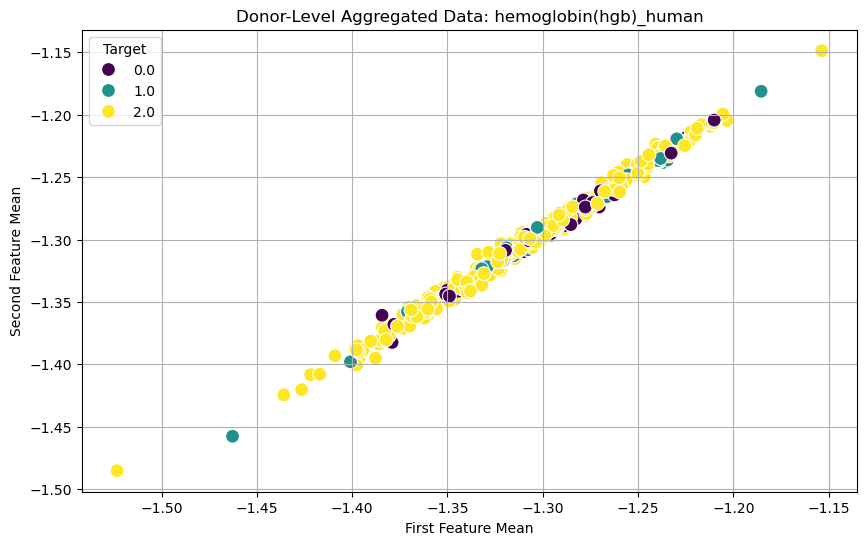

In [10]:
def analyze_donor_level(data, labels, donation_id_column, target_name, std_column=None):
    """
    Analyze donor-level data consistency and variation.

    Parameters:
    - data: Preprocessed spectral data.
    - labels: Corresponding labels for the data.
    - donation_id_column: Column indicating unique donor IDs.
    - target_name: Target variable for analysis.
    - std_column: Column for existing standard deviation in the train set.

    Returns:
    - donor_aggregated: Aggregated donor-level statistics.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    numeric_columns = data.select_dtypes(include="number").columns.tolist()
    if donation_id_column in numeric_columns:
        numeric_columns.remove(donation_id_column)
    if std_column in numeric_columns:
        numeric_columns.remove(std_column)

    donor_means = data.groupby(donation_id_column)[numeric_columns].mean()
    donor_stds = (
        data.groupby(donation_id_column)[numeric_columns].std()
        if std_column is None
        else data.groupby(donation_id_column)[std_column].mean()
    )

    donor_aggregated = pd.concat([donor_means, donor_stds.add_suffix('_std')], axis=1)

    labels_aligned = labels.groupby(data[donation_id_column]).mean()
    donor_aggregated[target_name] = labels_aligned[target_name]

    # Visualize donor-level aggregated statistics
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=donor_aggregated,
        x=donor_aggregated.iloc[:, 0], 
        y=donor_aggregated.iloc[:, 1],  
        hue=donor_aggregated[target_name],
        palette="viridis",
        s=100
    )
    plt.title(f"Donor-Level Aggregated Data: {target_name}")
    plt.xlabel("First Feature Mean")
    plt.ylabel("Second Feature Mean")
    plt.legend(title="Target")
    plt.grid()
    plt.show()
    
    return donor_aggregated

# Example usage
donor_summary_train = analyze_donor_level(
    X_train, y_train, 
    donation_id_column="donation_id",  
    target_name="hemoglobin(hgb)_human",
    std_column="std"  
)


In [11]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

# Redo Stratified K-Fold for each target
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Dictionary to store splits for each target
splits = {}

# Process each target
for target, X_target in target_to_dataset.items():
    
    # Get the corresponding labels
    y_target = y_train[target]
    
    # Compute Stratified K-Fold splits
    splits[target] = list(skf.split(X_target, y_target))

In [331]:
baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    # Access target-specific dataset and labels
    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        # Train the model
        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        # Validate the model
        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        # Store fold results
        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")



=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.9299
  Fold 2: Accuracy = 0.9268
  Fold 3: Accuracy = 0.9404
  Fold 4: Accuracy = 0.9302
  Fold 5: Accuracy = 0.9318

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 0.9229
  Fold 2: Accuracy = 0.9249
  Fold 3: Accuracy = 0.9235
  Fold 4: Accuracy = 0.9271
  Fold 5: Accuracy = 0.9266

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.9332
  Fold 2: Accuracy = 0.9363
  Fold 3: Accuracy = 0.9299
  Fold 4: Accuracy = 0.9296
  Fold 5: Accuracy = 0.9344

hdl_cholesterol_human Average Accuracy: 0.9318

hemoglobin(hgb)_human Average Accuracy: 0.9250

cholesterol_ldl_human Average Accuracy: 0.9326


In [332]:
baseline_model_params = {
   'max_depth': 30, 
    'min_samples_leaf': 1,
    'min_samples_split': 16, 
    'n_estimators': 230
}

target_to_dataset = {
    "hdl_cholesterol_human": (X_train_target1, X_test_target1),
    "hemoglobin(hgb)_human": (X_train_target2, X_test_target2),
    "cholesterol_ldl_human": (X_train_target3, X_test_target3),
}

test_predictions = {}

for target, (X_train_target, X_test_target) in target_to_dataset.items():
    print(f"Training model for {target} and predicting on the test set...")

    # Target-specific labels
    y_train_target = y_train[target]

    model = RandomForestClassifier(**baseline_model_params)
    model.fit(X_train_target, y_train_target)

    y_test_pred = model.predict(X_test_target)
    test_predictions[target] = y_test_pred

Training model for hdl_cholesterol_human and predicting on the test set...
Training model for hemoglobin(hgb)_human and predicting on the test set...
Training model for cholesterol_ldl_human and predicting on the test set...


In [333]:
decoding_map = {'hdl_cholesterol_human': {2:'ok', 1:'low', 0:'high'},
'hemoglobin(hgb)_human': {2:'ok', 1:'low', 0:'high'},
'cholesterol_ldl_human': {2:'ok', 1:'low', 0:'high'}} 
decoded_predictions = {}
for target_name, encoded_preds in test_predictions.items():
    decoded_predictions[target_name] = [decoding_map[target_name][pred] for pred in encoded_preds]

In [334]:
submission_data = []
test_ids = test['donation_id']
for i, test_id in enumerate(test_ids):
    submission_data.append({"Reading_ID": f"{test_id}_hdl_cholesterol_human", "target": decoded_predictions["hdl_cholesterol_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_hemoglobin(hgb)_human", "target": decoded_predictions["hemoglobin(hgb)_human"][i]})
    submission_data.append({"Reading_ID": f"{test_id}_cholesterol_ldl_human", "target": decoded_predictions["cholesterol_ldl_human"][i]})

submission_df = pd.DataFrame(submission_data)

submission_df.to_csv("submission_baseline_optim_new.csv", index=False)

In [63]:
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Objective function
def objective(params):
    # Unpack hyperparameters
    n_estimators = int(params["n_estimators"])
    max_depth = int(params["max_depth"])
    min_samples_split = int(params["min_samples_split"])
    min_samples_leaf = int(params["min_samples_leaf"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    accuracy = cross_val_score(model, X_train, y_train.iloc[:,0], cv=5, scoring="accuracy").mean()

    # Return negative accuracy (because Hyperopt minimizes)
    return {"loss": -accuracy, "status": STATUS_OK}

In [64]:
# Define the hyperparameter space
search_space = {
    "n_estimators": hp.quniform("n_estimators", 50, 300, 10),  
    "max_depth": hp.quniform("max_depth", 5, 50, 5),          
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1),  
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1)      
}

In [65]:
trials = Trials()

best_params = fmin(
    fn=objective,                
    space=search_space,          
    algo=tpe.suggest,            # Tree of Parzen Estimators (TPE) algorithm
    max_evals=10,                
    trials=trials,              
    rstate=np.random.default_rng(42)  
)

print("Best Hyperparameters:", best_params)

100%|██████████████████████████████████████████████| 10/10 [22:56<00:00, 137.60s/trial, best loss: -0.5928462709284628]
Best Hyperparameters: {'max_depth': 30.0, 'min_samples_leaf': 1.0, 'min_samples_split': 16.0, 'n_estimators': 230.0}


In [66]:
# Convert best_params to integers (if necessary)
best_params = {
    "n_estimators": int(best_params["n_estimators"]),
    "max_depth": int(best_params["max_depth"]),
    "min_samples_split": int(best_params["min_samples_split"]),
    "min_samples_leaf": int(best_params["min_samples_leaf"]),
}

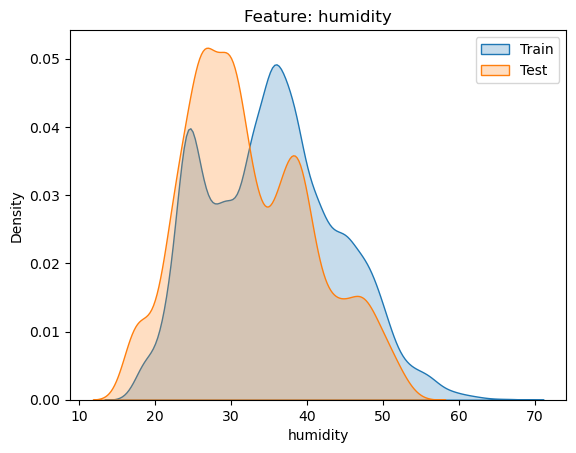

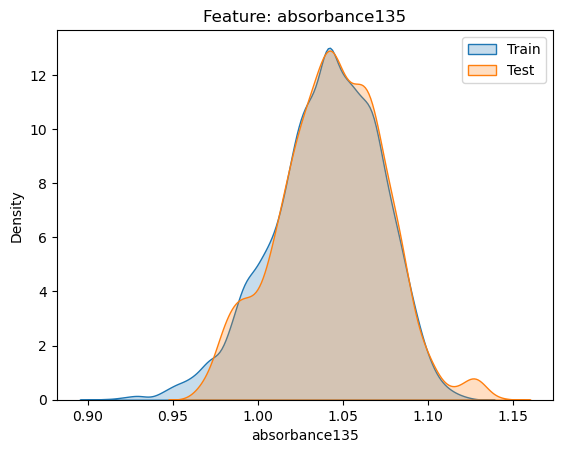

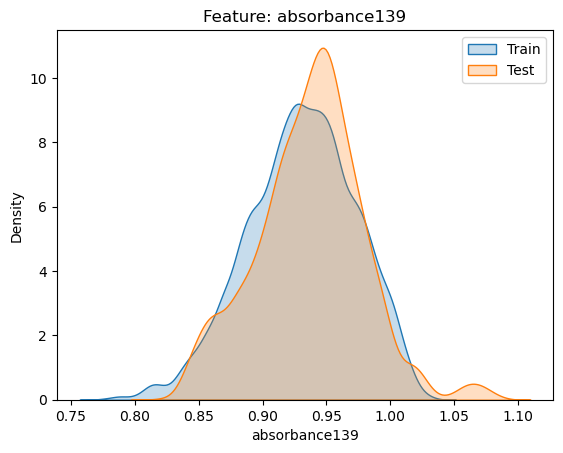

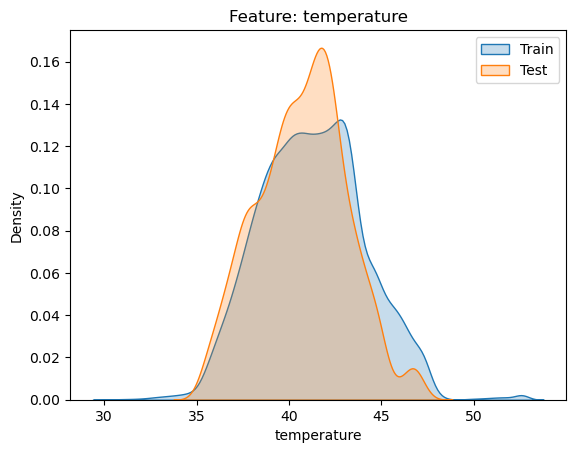

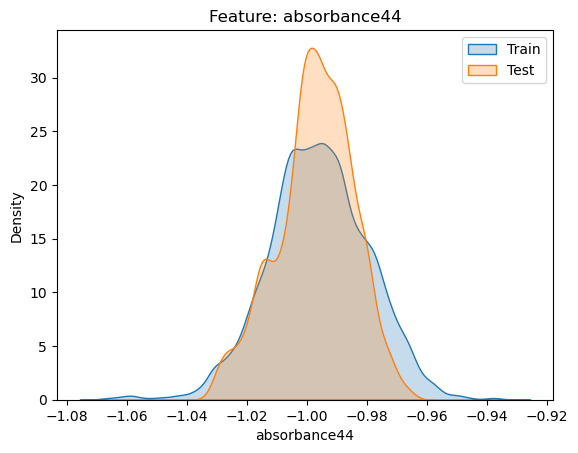

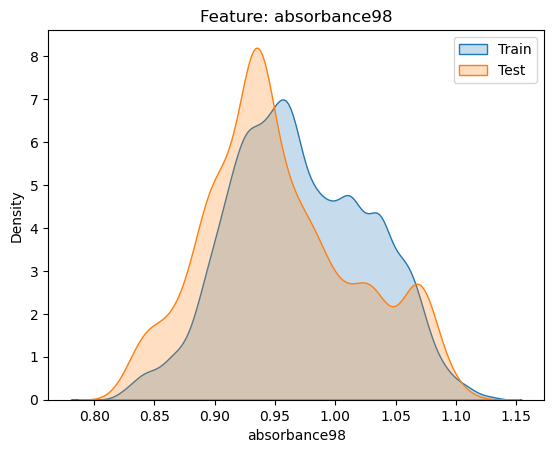

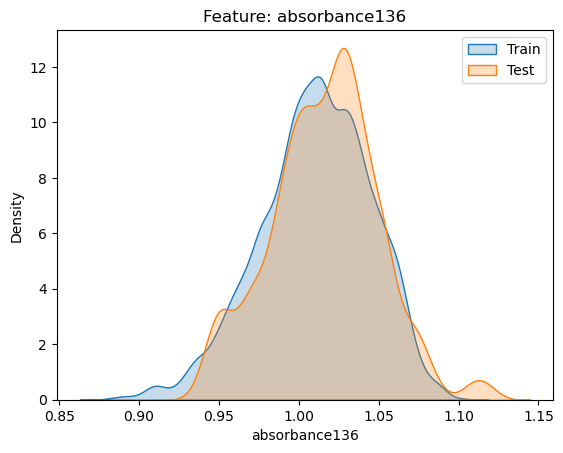

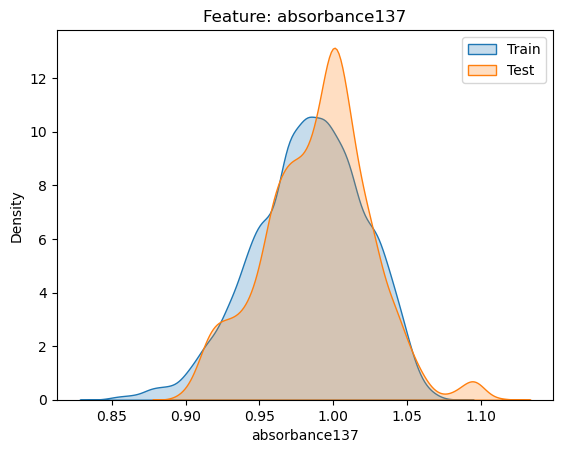

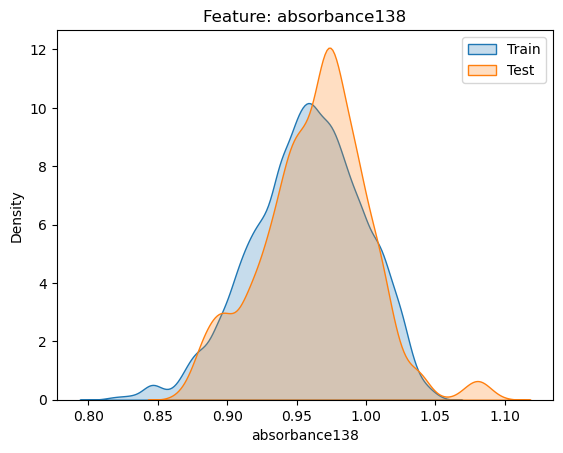

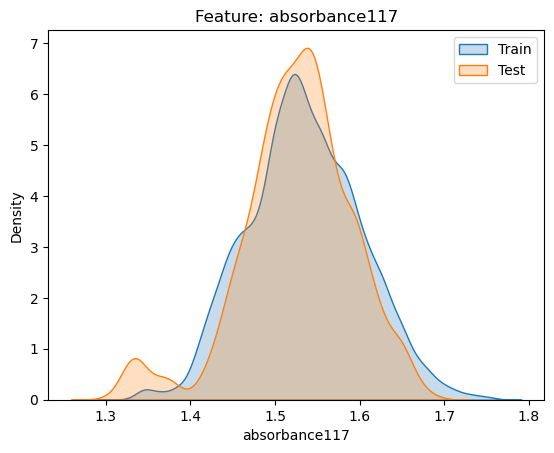

In [335]:
for column in X_train_target1.columns:
    sns.kdeplot(X_train_target1[column], label='Train', shade=True)
    sns.kdeplot(X_test[column], label='Test', shade=True)
    plt.title(f"Feature: {column}")
    plt.legend()
    plt.show()


In [336]:
from scipy.stats import ks_2samp
for col in X_train_target1.columns.tolist():
    stat, p_value = ks_2samp(X_train_target1[col], X_test[col])
    print(f"KS Statistic for {col}: {stat}, P-value: {p_value}")


KS Statistic for humidity: 0.20215931496817074, P-value: 5.953539260792967e-117
KS Statistic for absorbance135: 0.03148329671567798, P-value: 0.0031085580131470286
KS Statistic for absorbance139: 0.07943158131936229, P-value: 2.740547140051785e-18
KS Statistic for temperature: 0.1132933355867275, P-value: 8.3593660034426e-37
KS Statistic for absorbance44: 0.09723057855895445, P-value: 3.3329310852498825e-27
KS Statistic for absorbance98: 0.17334009351585822, P-value: 6.837146277180495e-86
KS Statistic for absorbance136: 0.07369387640132946, P-value: 8.448581856731699e-16
KS Statistic for absorbance137: 0.08468142639851273, P-value: 9.914415330729797e-21
KS Statistic for absorbance138: 0.08471297391696242, P-value: 9.574593484783472e-21
KS Statistic for absorbance117: 0.06952678722325512, P-value: 4.140105538691539e-14



Visualizing dataset shift for target: hdl_cholesterol_human


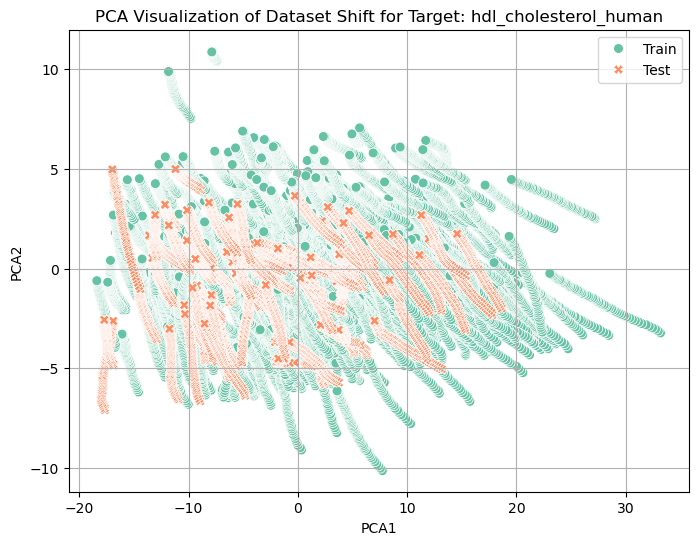


Visualizing dataset shift for target: hemoglobin(hgb)_human


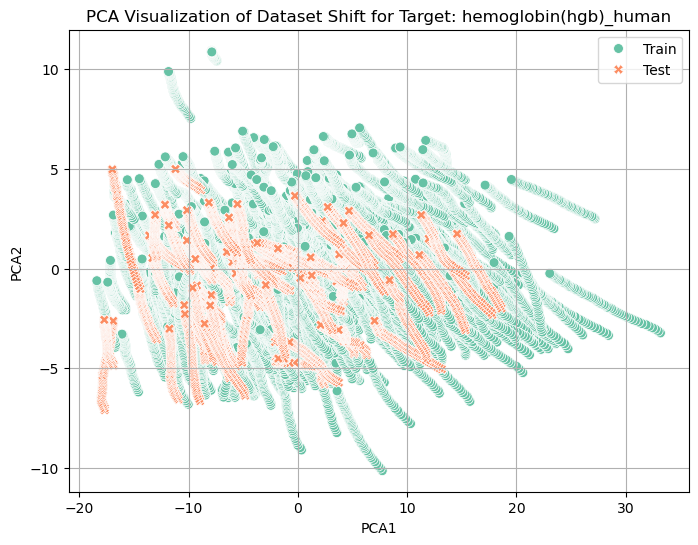


Visualizing dataset shift for target: cholesterol_ldl_human


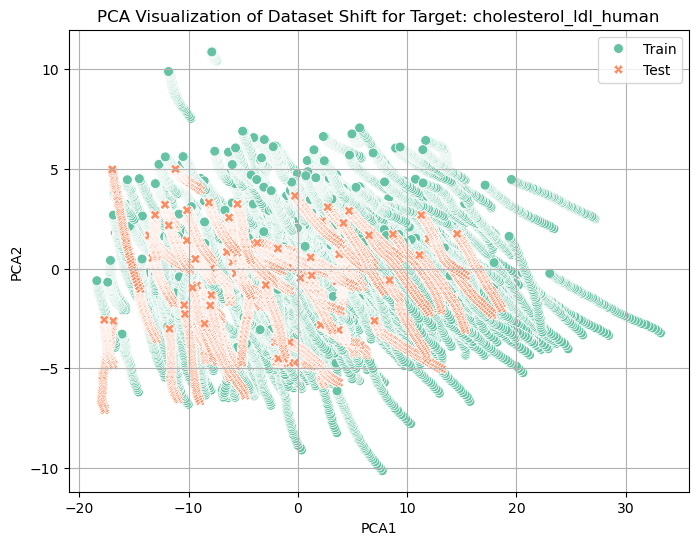

In [337]:
from sklearn.decomposition import PCA

# Function to visualize dataset shifts
def visualize_dataset_shift(X_train, X_test, target_name):
    """
    Visualizes the dataset shift between train and test sets for a given target using PCA.

    Parameters:
    - X_train: Train feature matrix (Pandas DataFrame).
    - X_test: Test feature matrix (Pandas DataFrame).
    - target_name: Name of the target being visualized (string).
    """
    print(f"\nVisualizing dataset shift for target: {target_name}")

    X_train['Dataset'] = 'Train'
    X_test['Dataset'] = 'Test'

    combined_data = pd.concat([X_train, X_test], axis=0)

    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(combined_data.drop('Dataset', axis=1))

    pca_df = pd.DataFrame(pca_data, columns=['PCA1', 'PCA2'])
    pca_df['Dataset'] = combined_data['Dataset'].values

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Dataset', style='Dataset', palette='Set2', s=50)
    plt.title(f"PCA Visualization of Dataset Shift for Target: {target_name}")
    plt.xlabel('PCA1')
    plt.ylabel('PCA2')
    plt.legend()
    plt.grid()
    plt.show()


visualize_dataset_shift(X_train_target1, X_test_target1, "hdl_cholesterol_human")
visualize_dataset_shift(X_train_target2, X_test_target2, "hemoglobin(hgb)_human")
visualize_dataset_shift(X_train_target3, X_test_target3, "cholesterol_ldl_human")


In [7]:
def group_train_data_by_donation_id(train_data, train_labels, donation_id_column, extra_columns):
    """
    Groups train data by `donation_id` and calculates mean for numeric features.

    Parameters:
    - train_data: DataFrame containing features and `donation_id`.
    - train_labels: DataFrame or Series containing target labels.
    - donation_id_column: The column name representing unique donor IDs.
    - target_columns: List of target column names to retain.

    Returns:
    - grouped_train_data: DataFrame with aggregated donor-level features and labels.
    """

    absorbance_columns = [col for col in train_data.columns if 'absorbance' in col and '_std' not in col]
    train_data = train_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = train_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    labels_aligned = train_labels.groupby(train_data[donation_id_column]).first()  # Use the first label for each donor
    grouped_train_data = donor_means.merge(labels_aligned[target_columns], left_index=True, right_index=True)

    return grouped_train_data

donation_id_column = 'donation_id'   
extra_columns = ['humidity', 'temperature']
# Group train data
grouped_train_data = group_train_data_by_donation_id(X_train, y_train, donation_id_column, extra_columns)

print(f"Grouped train data shape: {grouped_train_data.shape}")


Grouped train data shape: (485, 175)


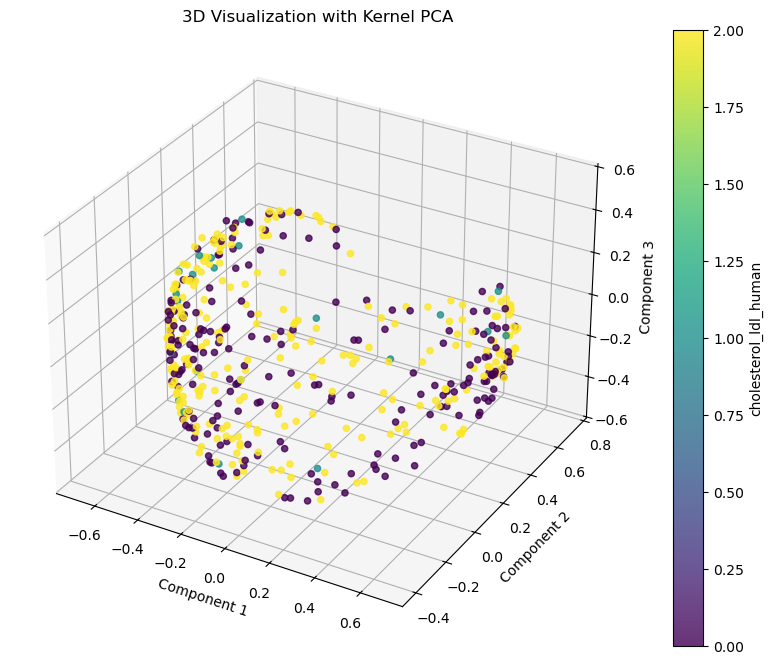

In [8]:
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D

def visualize_3d_nonlinear(data, target_column, n_components=3, kernel='rbf'):
    """
    Perform non-linear dimensionality reduction using Kernel PCA and visualize data in 3D.

    Parameters:
    - data: DataFrame containing the donor-level data (features and target).
    - target_column: Column name of the target variable for color coding.
    - n_components: Number of components for dimensionality reduction (default 3).
    - kernel: Kernel type for Kernel PCA (default 'rbf').

    Returns:
    - None (displays a 3D scatter plot).
    """
   
    features = data.drop(columns=[target_column]).values
    target = data[target_column].values
    
    # Apply Kernel PCA
    kpca = KernelPCA(n_components=n_components, kernel=kernel, random_state=42)
    transformed_features = kpca.fit_transform(features)
    
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        transformed_features[:, 0],
        transformed_features[:, 1],
        transformed_features[:, 2],
        c=target,
        cmap='viridis',
        alpha=0.8
    )
    
    plt.colorbar(scatter, label=target_column)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    ax.set_title("3D Visualization with Kernel PCA")
    plt.show()

visualize_3d_nonlinear(grouped_train_data, target_column='cholesterol_ldl_human')


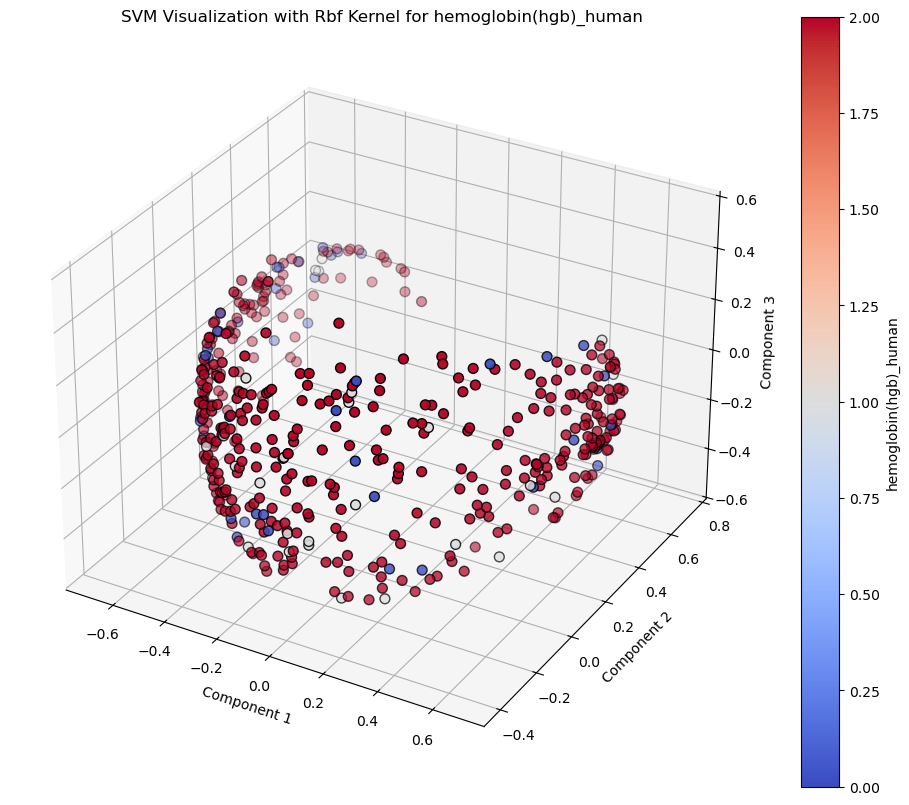

In [9]:
from sklearn.svm import SVC

def visualize_svm_with_kernel_3d(grouped_data, target_column, kernel):
    """
    Train and visualize SVM with kernel for grouped data in 3D.

    Parameters:
    - grouped_data: Grouped train data.
    - target_column: Name of the target variable.
    - kernel: Kernel type for SVM (e.g., 'rbf', 'poly').
    """
    features = grouped_data.drop(columns=target_columns)
    target = grouped_data[target_column]

    kpca = KernelPCA(n_components=3, kernel=kernel, random_state=42)
    reduced_features = kpca.fit_transform(features)

    svm_model = SVC(kernel=kernel, gamma='auto', C=1.0)
    svm_model.fit(reduced_features, target)

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        reduced_features[:, 2],
        c=target,
        cmap=plt.cm.coolwarm,
        edgecolor='k',
        s=50
    )

    ax.set_title(f"SVM Visualization with {kernel.capitalize()} Kernel for {target_column}")
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.set_zlabel("Component 3")
    fig.colorbar(scatter, ax=ax, label=target_column)

    plt.show()

target_column = 'hemoglobin(hgb)_human'  
visualize_svm_with_kernel_3d(grouped_train_data, target_column, kernel='rbf')


In [10]:
def group_test_data_by_donation_id(test_data, donation_id_column, extra_columns):
    """
    Groups test data by `donation_id` and calculates mean for numeric features, retaining specified extra columns.

    Parameters:
    - test_data: DataFrame containing features and `donation_id`.
    - donation_id_column: The column name representing unique donor IDs.
    - extra_columns: List of extra columns (e.g., humidity, temperature) to retain.

    Returns:
    - grouped_test_data: DataFrame with aggregated donor-level features.
    """
    if donation_id_column not in test_data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    absorbance_columns = [col for col in test_data.columns if 'absorbance' in col]
    test_data = test_data[[donation_id_column] + absorbance_columns + extra_columns]

    donor_means = test_data.groupby(donation_id_column)[absorbance_columns + extra_columns].mean()

    return donor_means


donation_id_column = 'donation_id' 
extra_columns = ['humidity', 'temperature']  
grouped_test_data = group_test_data_by_donation_id(X_test, donation_id_column, extra_columns)

print(f"Grouped test data shape: {grouped_test_data.shape}")


Grouped test data shape: (61, 172)


In [11]:
# Group the targets based on 'donation_id'
def group_targets_by_donation_id(data, target_column, donation_id_column):
    """
    Groups target values by donation_id.

    Parameters:
    - data: DataFrame containing the target values and the donation_id column.
    - target_column: Column name of the target to group.
    - donation_id_column: Column name for grouping.

    Returns:
    - grouped_targets: Series of grouped targets, indexed by donation_id.
    """
    if donation_id_column not in data.columns:
        raise KeyError(f"Column '{donation_id_column}' not found in the dataset.")

    grouped_targets = data.groupby(donation_id_column)[target_column].mean()
    return grouped_targets

# Example usage for each target
grouped_targets = {}
for target_column in ["hdl_cholesterol_human", "hemoglobin(hgb)_human", "cholesterol_ldl_human"]:
    grouped_targets[target_column] = group_targets_by_donation_id(
        y_train,
        target_column=target_column,
        donation_id_column="donation_id"
    )


In [12]:
# Apply selected features to the grouped data
X_train_target1 = grouped_train_data[selected_features["Target1"]]
X_train_target2 = grouped_train_data[selected_features["Target2"]]
X_train_target3 = grouped_train_data[selected_features["Target3"]]

X_test_target1 = X_test[selected_features["Target1"]]
X_test_target2 = X_test[selected_features["Target2"]]
X_test_target3 = X_test[selected_features["Target3"]]

In [13]:
from sklearn.model_selection import StratifiedKFold

# Map targets to their respective datasets
target_to_dataset = {
    "hdl_cholesterol_human": X_train_target1,
    "hemoglobin(hgb)_human": X_train_target2,
    "cholesterol_ldl_human": X_train_target3,
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

splits = {}

for target, X_target in target_to_dataset.items():
    
    y_target = grouped_targets[target]
    
    splits[target] = list(skf.split(X_target, y_target))

In [18]:
baseline_model = RandomForestClassifier(max_depth=15, min_samples_leaf=10,
                                       min_samples_split=15, n_estimators=160,
                                       random_state=42)

results = {}

for target, fold_splits in splits.items():
    print(f"\n=== Training Models for Target: {target} ===")

    X_target = target_to_dataset[target]
    y_target = y_train[target]

    results[target] = []

    # Iterate through folds
    for fold, (train_idx, val_idx) in enumerate(fold_splits):
        # Split the data
        X_train_fold = X_target.iloc[train_idx]
        X_val_fold = X_target.iloc[val_idx]
        y_train_fold = y_target.iloc[train_idx]
        y_val_fold = y_target.iloc[val_idx]

        model = baseline_model
        model.fit(X_train_fold, y_train_fold)

        y_val_pred = model.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        print(f"  Fold {fold + 1}: Accuracy = {accuracy:.4f}")

        results[target].append(accuracy)

# Summary of results
for target, accuracies in results.items():
    print(f"\n{target} Average Accuracy: {sum(accuracies) / len(accuracies):.4f}")


=== Training Models for Target: hdl_cholesterol_human ===
  Fold 1: Accuracy = 0.5052
  Fold 2: Accuracy = 0.6804
  Fold 3: Accuracy = 0.5670
  Fold 4: Accuracy = 0.6392
  Fold 5: Accuracy = 0.6082

=== Training Models for Target: hemoglobin(hgb)_human ===
  Fold 1: Accuracy = 1.0000
  Fold 2: Accuracy = 1.0000
  Fold 3: Accuracy = 1.0000
  Fold 4: Accuracy = 1.0000
  Fold 5: Accuracy = 1.0000

=== Training Models for Target: cholesterol_ldl_human ===
  Fold 1: Accuracy = 0.5052
  Fold 2: Accuracy = 0.4742
  Fold 3: Accuracy = 0.5258
  Fold 4: Accuracy = 0.5670
  Fold 5: Accuracy = 0.5361

hdl_cholesterol_human Average Accuracy: 0.6000

hemoglobin(hgb)_human Average Accuracy: 1.0000

cholesterol_ldl_human Average Accuracy: 0.5216
